In [1]:
#INSTALL DEPENDENCIES
!pip install -q transformers datasets peft accelerate bitsandbytes evaluate rouge_score bert-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.5 MB/s eta 0:00:00


In [2]:
#CHECKING GPU
!nvidia-smi

Thu Feb 19 08:50:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import json
import torch
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model

In [4]:
#LOADING DATASET
MEDQUAD = "lavita/MedQuAD"
MEDQUAD = load_dataset(MEDQUAD)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-e36383d177026d(…):   0%|          | 0.00/10.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/47441 [00:00<?, ? examples/s]

In [5]:
#SPLITTING THE DATASET
train = MEDQUAD["train"].train_test_split(test_size=0.3, seed=42)
test = train["test"].train_test_split(test_size=0.5, seed=42)

In [6]:
# Assign splits to descriptive variables
train_data = train["train"]
validation_data = test["train"]
test_data = test["test"]

In [7]:
# Print dataset sizes
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(validation_data)}")
print(f"Test size: {len(test_data)}")

Train size: 33208
Validation size: 7116
Test size: 7117


In [8]:
# LOADING BASE LINE MODEL
BASE_MODEL= "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
med_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
if med_tokenizer.pad_token is None:
    med_tokenizer.pad_token = med_tokenizer.eos_token
med_base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto"
)
med_base_model.config.pad_token_id = med_tokenizer.pad_token_id

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [9]:
# Evaluate Model Performance
def evaluate_med_model(model, eval_dataset, max_samples=50):
    all_predictions = []
    all_references = []
    for item in eval_dataset.select(range(min(max_samples, len(eval_dataset)))):
        question_text = str(item.get("question", "") or "").strip()
        reference_text = str(item.get("answer", "") or "").strip()
        if not question_text or not reference_text:
            continue
        predicted_answer = generate_answer(model, question_text)
        predicted_answer = str(predicted_answer or "").strip()
        all_predictions.append(predicted_answer)
        all_references.append(reference_text)
    if not all_predictions:
        print("No valid samples found!")
        return {}, {}
    rouge_scores = rouge.compute(predictions=all_predictions, references=all_references)
    bleu_scores = bleu.compute(
        predictions=all_predictions,
        references=[[ref] for ref in all_references]
    )
    return rouge_scores, bleu_scores

In [10]:
# Loading QLoRA (4-bit) TinyLlama Model
from transformers import BitsAndBytesConfig, AutoModelForCausalLM
# 4-bit quantization configuration
qlora_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)
qlora_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=qlora_config,
    device_map="auto",
    torch_dtype=torch.float16
)
if med_tokenizer.pad_token is None:
    med_tokenizer.pad_token = med_tokenizer.eos_token
qlora_model.config.pad_token_id = med_tokenizer.pad_token_id

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

In [11]:
# LoRA configuration
tiny_lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
med_lora_model = get_peft_model(qlora_model, tiny_lora_config)
med_lora_model.print_trainable_parameters()

trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044


In [12]:
# Tokenization & Preprocessing
MAX_SEQ_LENGTH = 256
def preprocess_med_sample(sample):
    question_text = str(sample.get("question", "") or "").strip()
    answer_text = str(sample.get("answer", "") or "").strip()
    if not question_text or not answer_text:
        return {
            "input_ids": [0] * MAX_SEQ_LENGTH,
            "attention_mask": [0] * MAX_SEQ_LENGTH,
            "labels": [-100] * MAX_SEQ_LENGTH
        }
    prompt_text = f"<|user|>\n{question_text}\n<|assistant|>\n"
    full_text = prompt_text + answer_text
    tokenized_output = med_tokenizer(
        full_text,
        truncation=True,
        padding="max_length",
        max_length=MAX_SEQ_LENGTH
    )
    labels = tokenized_output["input_ids"].copy()
    prompt_token_ids = med_tokenizer(
        prompt_text,
        truncation=True,
        max_length=MAX_SEQ_LENGTH
    )["input_ids"]

    labels[:len(prompt_token_ids)] = [-100] * len(prompt_token_ids)
    tokenized_output["labels"] = labels
    return tokenized_output

In [13]:
# Tokenize Train & Validation Datasets
train_tokenized_data = train_data.map(
    preprocess_med_sample,
    remove_columns=train_data.column_names,
    batched=False
)

validation_tokenized_data = validation_data.map(
    preprocess_med_sample,
    remove_columns=validation_data.column_names,
    batched=False
)

Map:   0%|          | 0/33208 [00:00<?, ? examples/s]

Map:   0%|          | 0/7116 [00:00<?, ? examples/s]

In [14]:
print(train_tokenized_data)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 33208
})


In [15]:
med_data_collator = DataCollatorForLanguageModeling(
    tokenizer=med_tokenizer,
    mlm=False
)
med_training_args = TrainingArguments(
    output_dir="./qlora_medical_model",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="none"
)
med_trainer = Trainer(
    model=med_lora_model,
    args=med_training_args,
    train_dataset=train_tokenized_data,
    eval_dataset=validation_tokenized_data,
    data_collator=med_data_collator
)
med_trainer.train()

Epoch,Training Loss,Validation Loss
1,6.962978,7.416275
2,7.547825,7.408675


TrainOutput(global_step=16604, training_loss=7.501372746518364, metrics={'train_runtime': 8891.4179, 'train_samples_per_second': 7.47, 'train_steps_per_second': 1.867, 'total_flos': 1.0576557536339558e+17, 'train_loss': 7.501372746518364, 'epoch': 2.0})

In [16]:
med_lora_model.save_pretrained("./qlora_medical_model")
med_tokenizer.save_pretrained("./qlora_medical_model")

('./qlora_medical_model/tokenizer_config.json',
 './qlora_medical_model/chat_template.jinja',
 './qlora_medical_model/tokenizer.json')

In [17]:
# Loading Evaluation Metrics
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")
device = "cuda" if torch.cuda.is_available() else "cpu"

def generate_med_answer(model, question_text, max_input_length=256, max_output_tokens=100):
    if not question_text:
        return ""
    model.eval()
    prompt_text = f"<|user|>\n{question_text}\n<|assistant|>\n"
    inputs = med_tokenizer(
        prompt_text,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_length
    ).to(device)
    with torch.no_grad():
        generated_outputs = model.generate(
            **inputs,
            max_new_tokens=max_output_tokens,
            do_sample=False,
            pad_token_id=med_tokenizer.pad_token_id
        )
    decoded_text = med_tokenizer.decode(generated_outputs[0], skip_special_tokens=True)
    answer_text = decoded_text.replace(prompt_text, "").strip()
    return answer_text

# Evaluating Model Performance
def evaluate_med_model(model, eval_dataset, max_samples=50):
    all_predictions = []
    all_references = []
    for item in eval_dataset.select(range(min(max_samples, len(eval_dataset)))):
        question_text = str(item.get("question", "") or "").strip()
        reference_text = str(item.get("answer", "") or "").strip()
        if not question_text or not reference_text:
            continue
        predicted_answer = generate_med_answer(model, question_text) or ""
        all_predictions.append(predicted_answer)
        all_references.append(reference_text)
    if not all_predictions:
        print("No valid samples found!")
        return {}, {}
    rouge_scores = rouge_metric.compute(predictions=all_predictions, references=all_references)
    bleu_scores = bleu_metric.compute(
        predictions=all_predictions,
        references=[[ref] for ref in all_references]
    )
    return rouge_scores, bleu_scores

In [19]:
#QLoRA Evaluation
qlora_rouge_scores, qlora_bleu_scores = evaluate_med_model(med_lora_model, test_data)
metrics_output = {
    "rouge": qlora_rouge_scores,
    "bleu": qlora_bleu_scores
}
def convert_numpy(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(v) for v in obj]
    elif isinstance(obj, np.generic):
        return obj.item()
    else:
        return obj
clean_metrics = convert_numpy(metrics_output)
print("\nQLoRA ROUGE Scores:")
pprint(clean_metrics["rouge"], width=60)

print("\nQLoRA BLEU Scores:")
pprint(clean_metrics["bleu"], width=60)

with open("qlora_medical_metrics.json", "w") as metrics_file:
    json.dump(clean_metrics, metrics_file, indent=4)


QLoRA ROUGE Scores:
{'rouge1': 0.40666853337397657,
 'rouge2': 0.25940733466697397,
 'rougeL': 0.33941864433908486,
 'rougeLsum': 0.34546105427450524}

QLoRA BLEU Scores:
{'bleu': 0.09142474132416235,
 'brevity_penalty': 0.251129182021105,
 'length_ratio': 0.4198526832690284,
 'precisions': [0.5513784461152882,
                0.37341236240474174,
                0.3072961373390558,
                0.27763272410791995],
 'reference_length': 2851,
 'translation_length': 1197}


In [20]:
baseline_rouge_scores, baseline_bleu_scores = evaluate_med_model(med_base_model, test_data)
# Baseline Evaluation
def convert_numpy(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(v) for v in obj]
    elif isinstance(obj, np.generic):
        return float(obj)
    else:
        return obj
clean_baseline = {
    "rouge": convert_numpy(baseline_rouge_scores),
    "bleu": convert_numpy(baseline_bleu_scores)
}
print("\nBaseline ROUGE Scores:")
pprint(clean_baseline["rouge"], width=60)

print("\nBaseline BLEU Scores:")
pprint(clean_baseline["bleu"], width=60)


Baseline ROUGE Scores:
{'rouge1': 0.27187040050913946,
 'rouge2': 0.09006424218979,
 'rougeL': 0.1863696890617597,
 'rougeLsum': 0.19884595763579543}

Baseline BLEU Scores:
{'bleu': 0.01731471791956396,
 'brevity_penalty': 0.16248108631577549,
 'length_ratio': 0.3549631708172571,
 'precisions': [0.4268774703557312,
                0.14156626506024098,
                0.06428571428571428,
                0.03319502074688797],
 'reference_length': 2851,
 'translation_length': 1012}


In [21]:
# Compare Baseline vs QLoRA Model
comparison_results = pd.DataFrame({
    "Model": ["Baseline (Phi-2)", "QLoRA Fine-Tuned"],
    "ROUGE-L": [
        baseline_rouge_scores.get("rougeL", 0.0),
        qlora_rouge_scores.get("rougeL", 0.0)
    ],
    "BLEU": [
        baseline_bleu_scores.get("bleu", 0.0),
        qlora_bleu_scores.get("bleu", 0.0)
    ]
})
print(comparison_results)
comparison_results.to_csv("med_model_comparison.csv", index=False)

              Model   ROUGE-L      BLEU
0  Baseline (Phi-2)  0.186370  0.017315
1  QLoRA Fine-Tuned  0.339419  0.091425


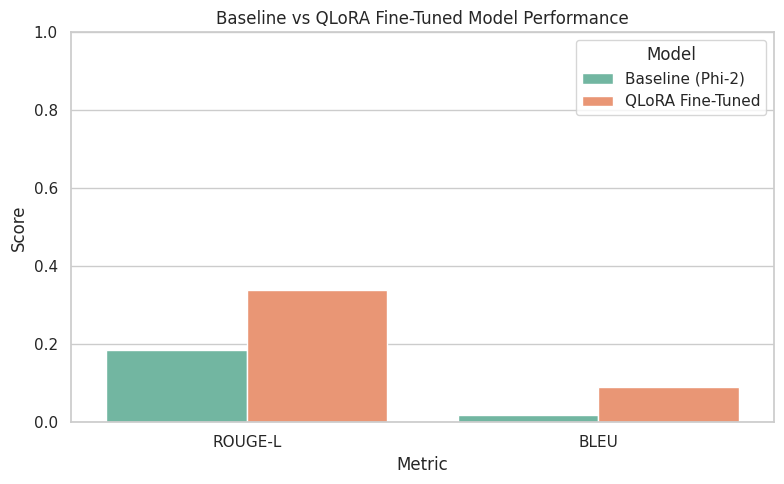

In [22]:
# Model Comparison
sns.set(style="whitegrid")
plot_data = comparison_results.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(8, 5))
sns.barplot(x="Metric", y="Score", hue="Model", data=plot_data, palette="Set2")
plt.title("Baseline vs QLoRA Fine-Tuned Model Performance")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model")
plt.tight_layout()
plt.show()